# 0. Opdracht Beschrijving

## 0.1. Probleemstelling

Bij onderzoeken naar gewelddadige misdrijven zoals overvallen en schietincidenten is het voor de FBI vaak lastig om snel en betrouwbaar vast te stellen welk type vuurwapen is gebruikt. In veel gevallen is direct fysiek bewijs beperkt of nog niet beschikbaar, terwijl er wel andere vormen van informatie aanwezig zijn, zoals geluidsopnames van schoten, afbeeldingen van wapens of tekstuele beschrijvingen in rapporten en getuigenverklaringen. Het ontbreken van een duidelijke vaststelling van het wapentype kan het opsporingsproces vertragen en de onderbouwing van bewijs in de rechtbank verzwakken. Het doel van ons project is het ontwikkelen van een data engineering pipeline die audio, afbeeldingen en tekst data samenbrengt om het type vuurwapen te voorspellen. Het "model" richt zich op het classificeren van wapens in categorieen zoals pistool, rifle of shotgun wapen. Door kenmerken zoals schiet tempo, kaliber, actie-type en fysieke eigenschappen van het wapen te combineren, kan het systeem de FBI ondersteunen bij het inschatten van het type misdrijf en de ernst ervan. Hiermee wordt het analyseproces versneld en wordt aanvullende objectieve ondersteuning geleverd voor strafzaken.

## 0.2. Zakelijke Inzicht En Literatuur Onderzoek

Vanuit zakelijk perspectief is dit project gericht op het ondersteunen van FBI-rechercheurs bij het herkennen van het type vuurwapen dat is gebruikt bij een misdrijf. Deze informatie kan helpen om een zaak beter te begrijpen en sneller beslissingen te nemen tijdens een onderzoek. Het systeem is bedoeld als een extra informatiebron die wordt gecombineerd met ander bewijsmateriaal.

Het onderzoek binnen dit project richt zich op het vinden en gebruiken van geschikte databronnen voor het automatisch herkennen van vuurwapentypen. Voor audio is een publieke Kaggledataset met vuurwapengeluiden gebruikt, waarmee kenmerken zoals het gemiddeld aantal schoten per tijdseenheid kunnen worden bepaald. Tekstuele informatie is verzameld via webscraping van Guns Fandom, waar beschrijvingen van wapens beschikbaar zijn. Afbeeldingen van vuurwapens zijn opgehaald via de Wikimedia Commons API. De data uit deze bronnen bestaan uit ongestructureerde en semi-gestructureerde formaten en worden verwerkt tot een gestructureerde dataset die geschikt is voor verdere analyse en classificatie.

# 1. Imports En Data Extraction

## 1.1 Packages

In [1]:
import pandas as pd
import numpy as np
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import librosa
import random
import time
import requests
from urllib.parse import unquote

## 1.2 Audio Dataset Van kaggle.com

Voor de audioanalyse wordt een publieke Kaggle dataset met vuurwapengeluiden gebruikt. De dataset bevat 58 verschillende vuurwapens, waarbij per vuurwapen meerdere korte audiofragmenten beschikbaar zijn. Elk audiofragment heeft een vaste lengte van 0,5 seconde en bevat een schot of korte schotreeks. Deze dataset is als eerste gekozen, omdat geschikte audiodata het moeilijkst te vinden was voor dit project. De audio vormt daarom de basis van de verdere dataverzameling. De audiobestanden zijn gestructureerd in mappen met de naam van het vuurwapen, waardoor deze mapnamen gebruikt kunnen worden als metadata. Op basis hiervan is een dataframe opgebouwd waarin het vuurwapenmodel en het bijbehorende audio zijn vastgelegd.

In [2]:
audio_path = "data/audio/original_dataset/"
audio_files = os.listdir(audio_path)
audio_df = pd.DataFrame({
    'model': [os.path.splitext(f)[0] for f in audio_files],
    'path': [os.path.join(audio_path, f) for f in audio_files]
})
print(audio_df.head(70))

                          model  \
0           38sws-dot38-caliber   
1                         ak-12   
2                         ak-47   
3         arctic-warfare-magnum   
4                    beretta-92   
5                     colt-1911   
6                     daewoo-k2   
7                  desert-eagle   
8         double-barrel-shotgun   
9                     dp-27-lmg   
10                       fn-p90   
11                      fn-scar   
12                        glock   
13                    glock-18c   
14    glock-19-9mm-luger-pistol   
15           high-standard-22lr   
16                      hk-g36c   
17                     hk-ump45   
18  hk-usp-compact-40-sw-pistol   
19                       kar98k   
20                 kimber-45acp   
21                 kriss-vector   
22                lorcin-380acp   
23                          m16   
24                      m24-sws   
25                     m249-lmg   
26                           m4   
27                  

## 1.3 Image API Van wikimedia.org

Voor de beeldanalyse wordt gebruikgemaakt van afbeeldingen die via de Wikimedia Commons API zijn opgehaald. Wikimedia is gekozen omdat het een grote, publieke en vrij toegankelijke verzameling bevat van vuurwapenafbeeldingen, gestructureerd per categorie en voorzien van metadata. De afbeeldingen worden opgehaald op basis van modelnamen van vuurwapens, die eerder zijn verkregen uit de audiodataset. Hierdoor kan dezelfde firearm naam worden gebruikt over meerdere databronnen heen. De Wikimedia API levert semi-gestructureerde data in JSON-formaat. Eerst wordt via een zoekquery gezocht naar relevante afbeelding titels binnen de bestanden. Vervolgens worden per titel de directe image URL’s opgevraagd en lokaal opgeslagen. Alleen bestanden met een geldig image content type worden geaccepteerd, zodat niet relevante resultaten zoals documenten of HTML-pagina’s worden gefilterd. De opgehaalde afbeeldingen worden opgeslagen als JPG-bestanden, met daarnaast een csv-bestand waarin per afbeelding het vuurwapenmodel, de bron URL en het lokale bestandspad zijn vastgelegd. Deze metadata maakt het mogelijk om de afbeeldingen later te koppelen aan andere modaliteiten in het project. De beelden worden in een volgende stap gebruikt voor eenvoudige image analyse, zoals het bepalen van grip_style (eenhandig of tweehandig) en barrel_length (kort of lang). Op deze manier vormt de Wikimedia API een betrouwbare en schaalbare bron voor visuele informatie binnen de multimodale dataset.

In [ ]:
from image_api import ImageAPI
API_URL = "https://commons.wikimedia.org/w/api.php"
HEADERS = {"User-Agent": "Pipline/1.0 (mkakol.index@gmail.com)"}
audio_files = os.listdir(audio_path)
models = [os.path.splitext(f)[0] for f in audio_files]
image_df = ImageAPI(API_URL, HEADERS).fetch_images_for_models(models)

Searching for 38sws-dot38-caliber...
No image found for 38sws-dot38-caliber.
Searching for ak-12...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/c2/5%2C45mm_AK-12_6P70_assault_rifle_at_Military-technical_forum_ARMY-2016_03_noBG.png
Searching for ak-47...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/f/f6/AK-47_assault_rifle.jpg
Searching for arctic-warfare-magnum...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/0/0f/AWM-338-white.jpg
Searching for beretta-92...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/2/24/Beretta_92S_%28cropped%29.jpg
Searching for colt-1911...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/cf/Colt_M1911_Pistol_from_1912_Army_manual.png
Searching for daewoo-k2...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/5/59/Daewoo_K2_rifle_1.jpg
Searching for desert-eagle...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/8/81/2014-_Desert_Eagle_.50_Action_Express_Semi-Automatic_Pis

## 1.4 Web Scraping Text Van gunsfandom.com

Voor het bepalen van het wapen type wordt tekstuele informatie verzameld van GunsFandom.com. Deze website is gekozen omdat per vuurwapen een beschrijvende introductietekst beschikbaar is waarin vaak expliciet wordt aangegeven om welk type wapen het gaat, zoals bijvoorbeeld assault rifle, pistol of shotgun. Deze beschrijving vormt de basis voor de targetvariabele weapon_type en is daarmee een belangrijk onderdeel van de classificatie.

Een eerdere aanpak, waarbij direct pagina-URL’s werden opgebouwd op basis van de vuurwapennaam of waarbij vaste pagina elementen werden aangesproken, bleek in de praktijk onvoldoende betrouwbaar. Dit kwam onder andere doordat GunsFandom gebruikmaakt van JavaScript gegenereerde content en doordat vuurwapennamen niet altijd exact overeenkomen met de daadwerkelijke paginanamen op de website. Hierdoor werden pagina’s regelmatig niet gevonden of werd onjuiste inhoud opgehaald. Om dit probleem te verhelpen wordt nu gebruikgemaakt van een zoekgebaseerde web scraping aanpak. Voor elk vuurwapenmodel wordt eerst de interne zoekfunctie van GunsFandom gebruikt om de juiste pagina te vinden. Vervolgens wordt de bijbehorende vuurwapenpagina opgehaald en wordt de eerste betekenisvolle paragraaf uit de hoofdtekst geextraheerd. Deze paragraaf bevat doorgaans een algemene beschrijving van het wapen en vormt daarmee een consistente bron van informatie.

De verkregen tekstdata is ongestructureerd en wordt in eerste instantie ongewijzigd opgeslagen, zodat de originele terminologie van de bron behouden blijft. In een latere fase van feature engineering wordt deze tekst omgezet naar gestandaardiseerde categorieen (zoals pistol, rifle en shotgun) die uiteindelijk worden gebruikt als target voor het "classificatiemodel".

In [ ]:
from text_webscraping import get_fandom_text
url = "https://guns.fandom.com/wiki/AK-47"
paras = get_fandom_text(url)
for i, p in enumerate(paras[:10]):
    print(p)

In [3]:
from text_webscraping import get_fandom_texts
text_df = get_fandom_texts(audio_df)
pd.set_option("display.max_colwidth", None)
print(text_df)

                          model  \
0           38sws-dot38-caliber   
1                         ak-12   
2                         ak-47   
3         arctic-warfare-magnum   
4                    beretta-92   
5                     colt-1911   
6                     daewoo-k2   
7                  desert-eagle   
8         double-barrel-shotgun   
9                     dp-27-lmg   
10                       fn-p90   
11                      fn-scar   
12                        glock   
13                    glock-18c   
14    glock-19-9mm-luger-pistol   
15           high-standard-22lr   
16                      hk-g36c   
17                     hk-ump45   
18  hk-usp-compact-40-sw-pistol   
19                       kar98k   
20                 kimber-45acp   
21                 kriss-vector   
22                lorcin-380acp   
23                          m16   
24                      m24-sws   
25                     m249-lmg   
26                           m4   
27                  

# 2. EDA

## 2.1 Audio EDA

We nemen de audio dataset als basis, omdat deze als enige direct gestructureerd is. Elke subfolder is genoemd naar een firearm, wat we gebruiken als identifier om data te koppelen aan afbeeldingen of tekst. Zo hoeven we de namen niet handmatig in te vullen en vormt het een natuurlijke basis voor de pipeline.

De dataset bevat 1450 bestanden, verdeeld over 58 unieke vuurwapens, dus 25 audio’s per wapen. Dit helpt om de variatie in geluid per wapen te bekijken. Het doel is het berekenen van avg_shots_per_sec en kijken naar correlatie met de target weapon_type (pistol, rifle, shotgun).

Elke sample is 0,5 seconde lang, met een sample rate van 22050 Hz. Het exact detecteren van schoten bleek lastig, daarom is een aangepaste functie gebruikt die RMS-energie van de audio berekent om de pieken stabieler te detecteren. Door parameters voor prominente pieken, minimumhoogte en minimale afstand tussen pieken aan te passen, kan de functie best wel betrouwbaar zien of er een of meerdere schoten in een fragment zijn, ook bij korte clips met echo of ruis.

Voor feature engineering trekken we metadata uit de audio: het aantal gedetecteerde pieken voor avg_shots_per_sec en de amplitude voor avg_loudness. Signalen bevatten veel ruis, maar meestal overheerst een duidelijke frequentie, waardoor een uitgebreide Fourier analyse niet nodig is. Gemeten minimum en piekfrequenties liggen tussen 2 en 3844 Hz, wat bruikbaar is voor het beoordelen van het volume en de schot activiteit.

Audio files: 1450
Unique firearms: 58
Audios per firearm: {'38sws-dot38-caliber': 25, 'ak-12': 25, 'ak-47': 25, 'arctic-warfare-magnum': 25, 'beretta-92': 25, 'colt-1911': 25, 'daewoo-k2': 25, 'desert-eagle': 25, 'double-barrel-shotgun': 25, 'dp-27-lmg': 25, 'fn-p90': 25, 'fn-scar': 25, 'glock': 25, 'glock-18c': 25, 'glock-19-9mm-luger-pistol': 25, 'high-standard-22lr': 25, 'hk-g36c': 25, 'hk-ump45': 25, 'hk-usp-compact-40-sw-pistol': 25, 'kar98k': 25, 'kimber-45acp': 25, 'kriss-vector': 25, 'lorcin-380acp': 25, 'm16': 25, 'm24-sws': 25, 'm249-lmg': 25, 'm4': 25, 'mg42-lmg': 25, 'mini-14': 25, 'mk14-ebr': 25, 'mp-40-40-sw-pistol': 25, 'mp5-smg': 25, 'nagant-m1895': 25, 'ots-14-groza': 25, 'pp-19-bizon': 25, 'pump-action-shotgun': 25, 'qbu-88': 25, 'qbz-95': 25, 'remington-22lr': 25, 'remington-700': 25, 'remington-870': 25, 'rhino-60ds': 25, 'ruger-22lr': 25, 'ruger-357': 25, 'ruger-ar-556': 25, 'saiga-12k': 25, 'sig-p225': 25, 'sks-rifle': 25, 'slr-rifle': 25, 'steyr-aug': 25, 'sw-10-

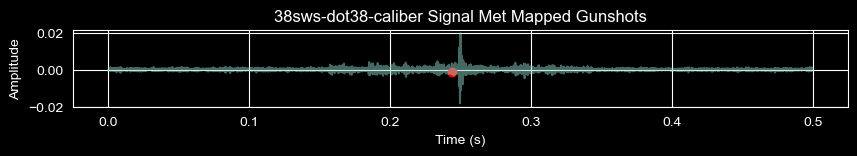

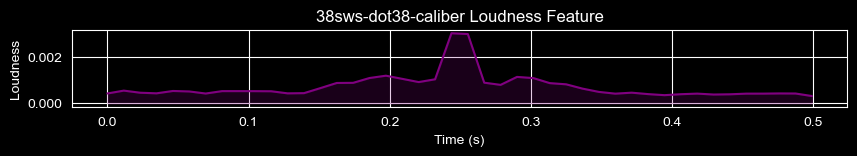

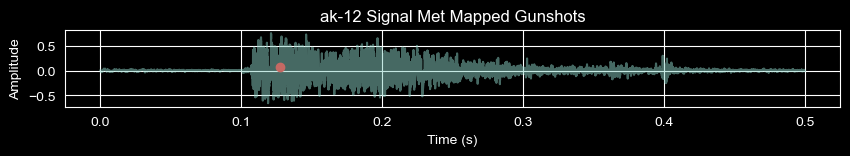

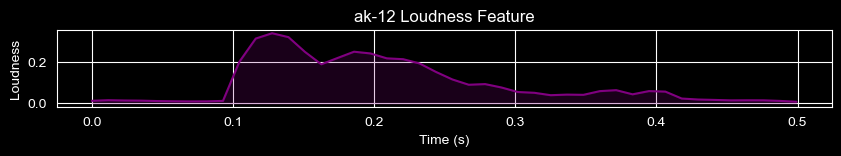

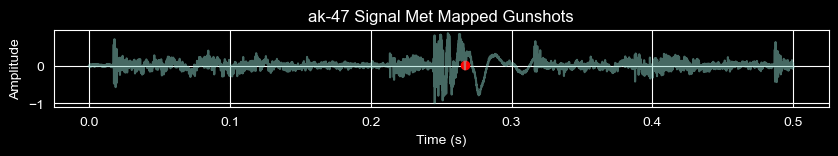

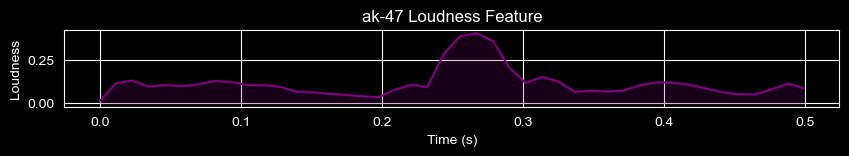

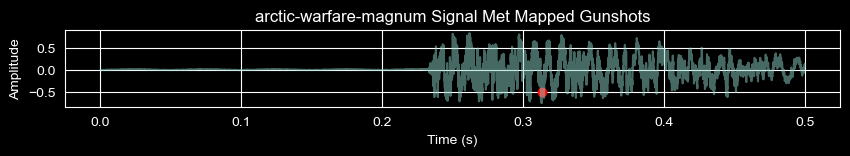

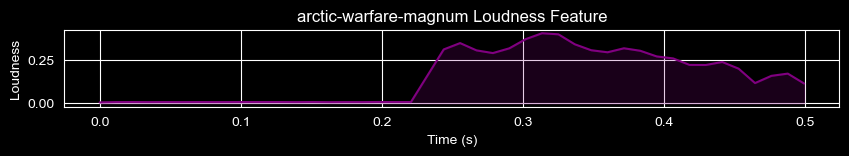

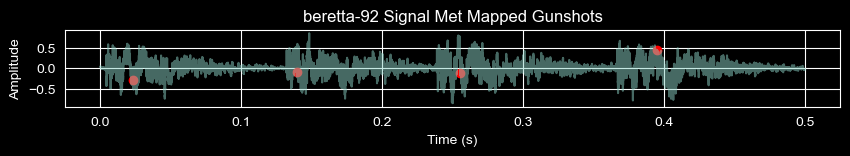

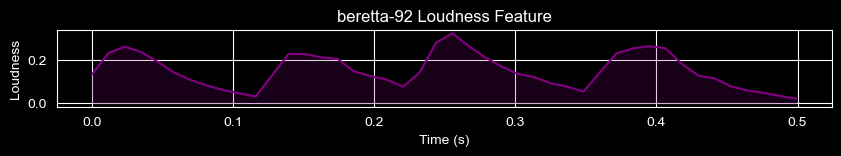

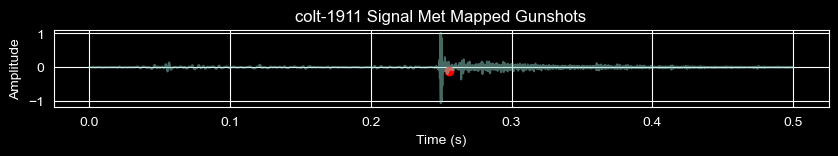

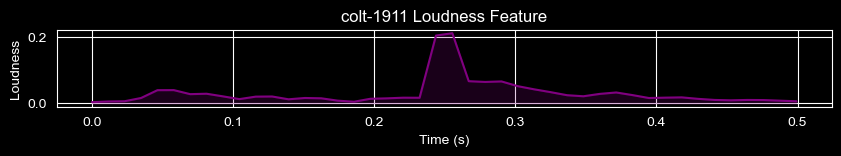

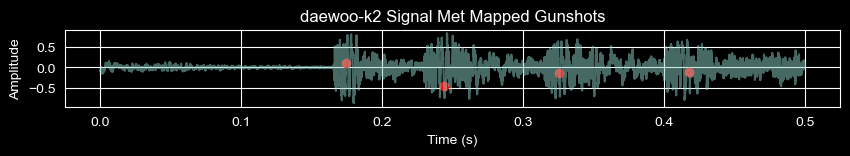

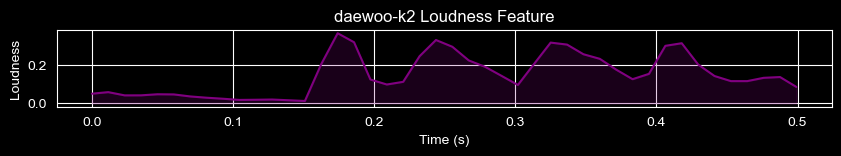

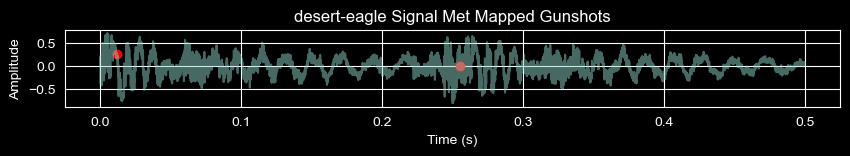

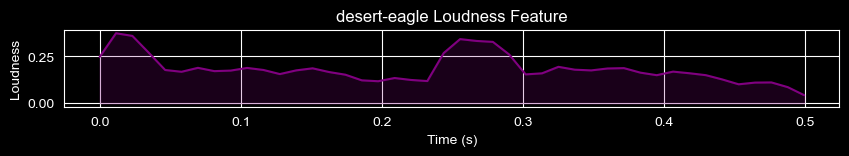

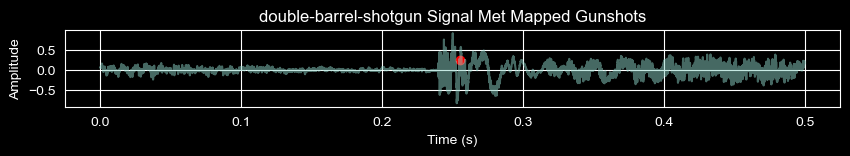

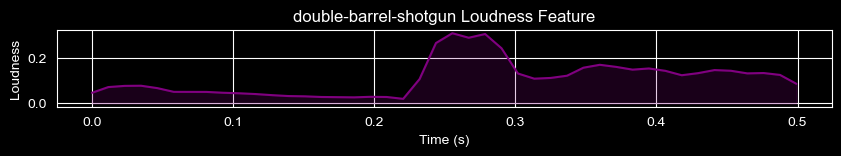

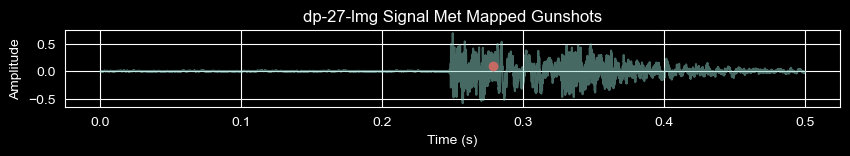

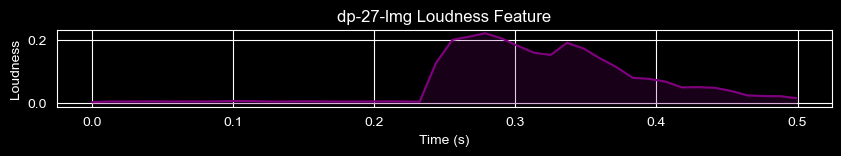

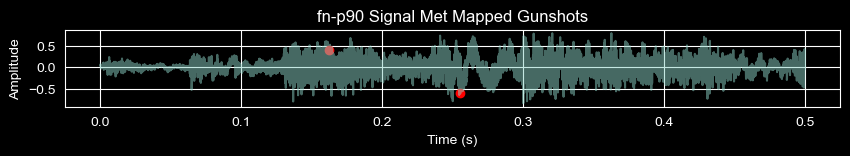

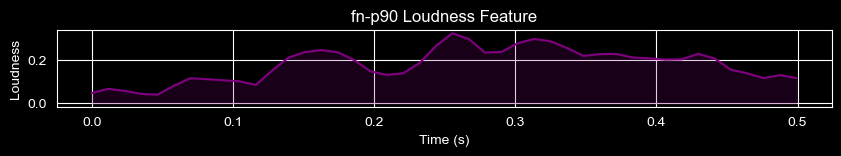

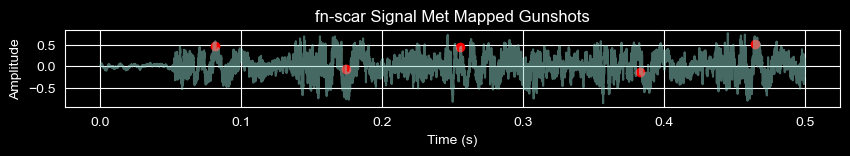

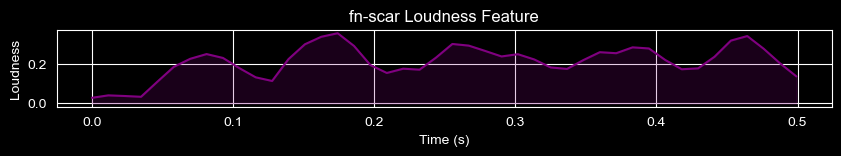

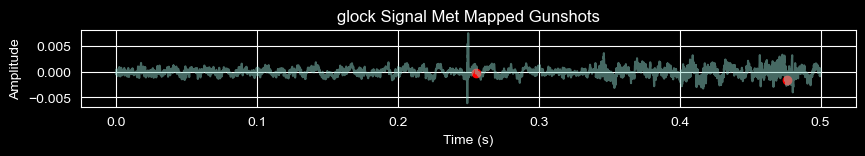

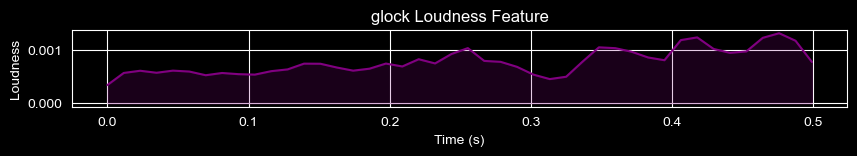

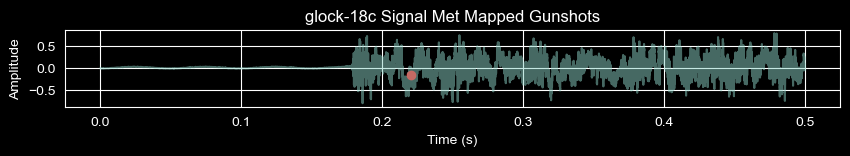

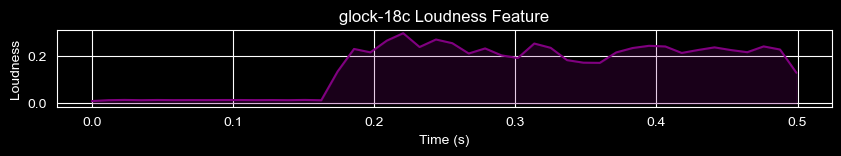

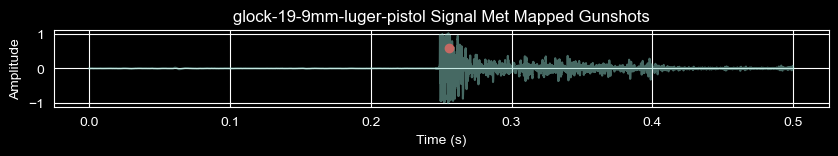

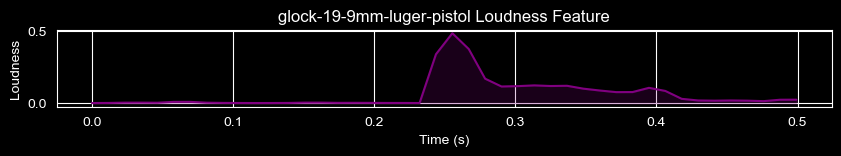

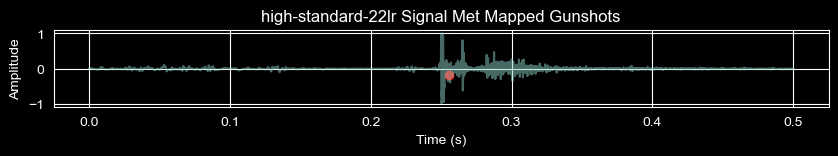

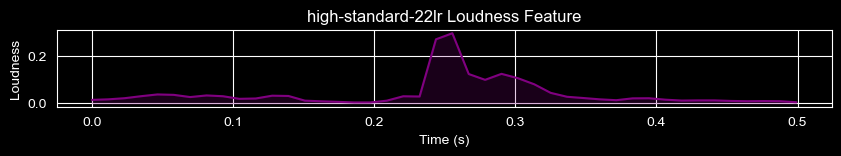

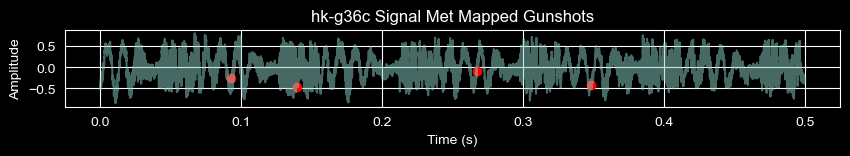

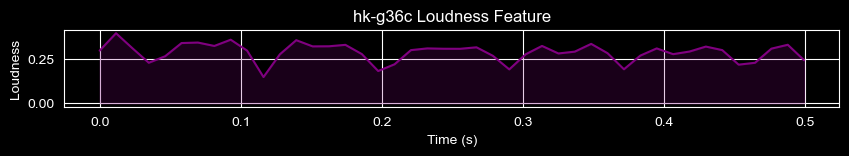

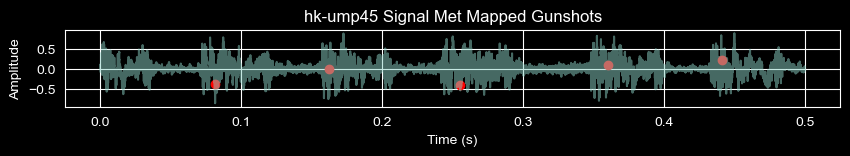

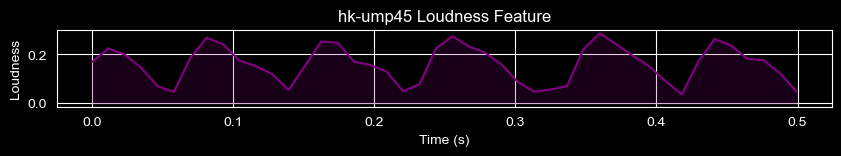

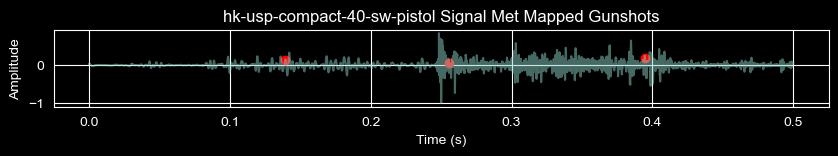

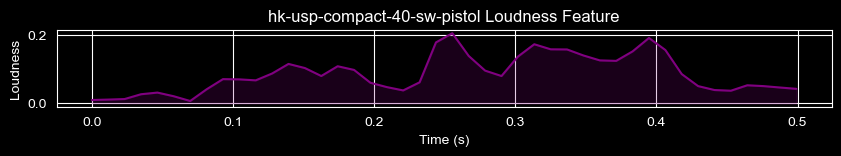

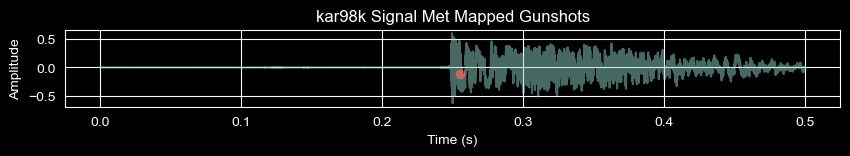

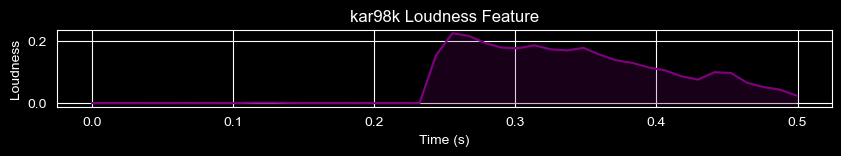

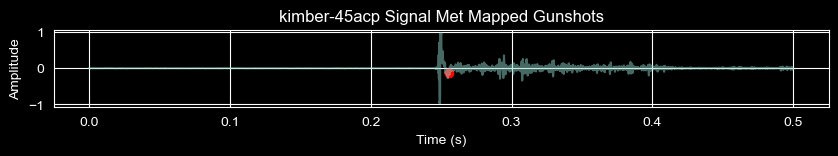

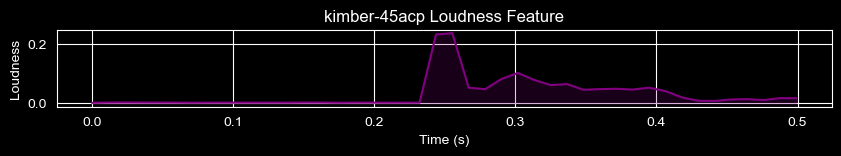

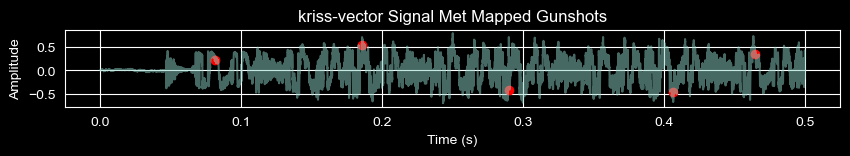

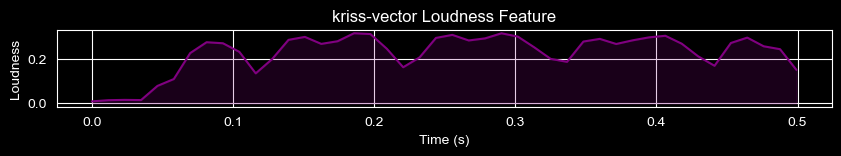

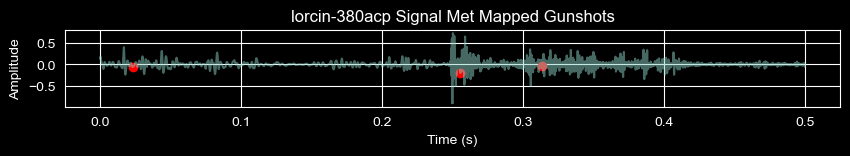

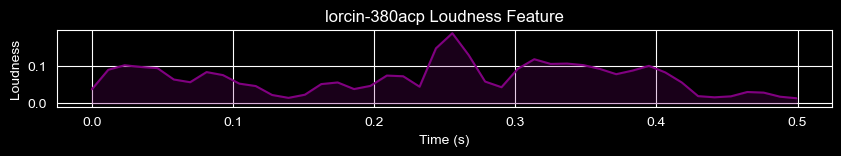

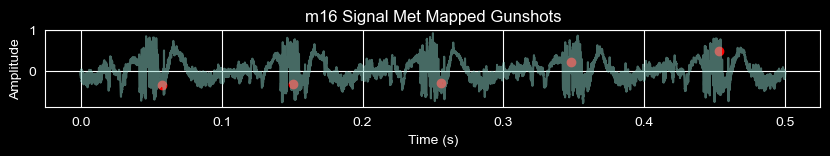

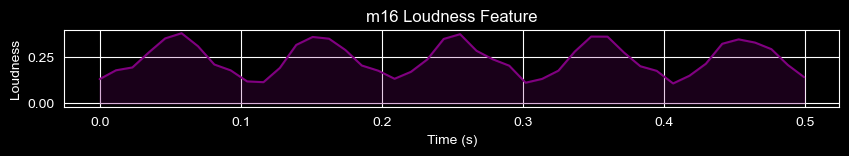

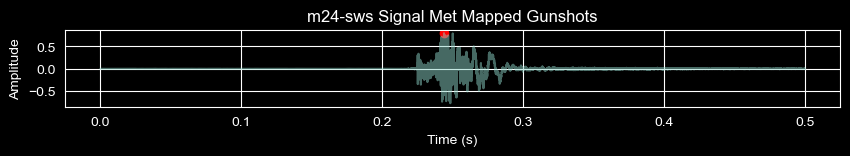

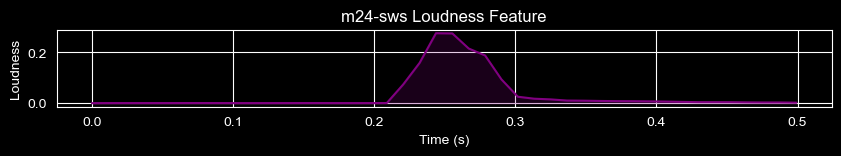

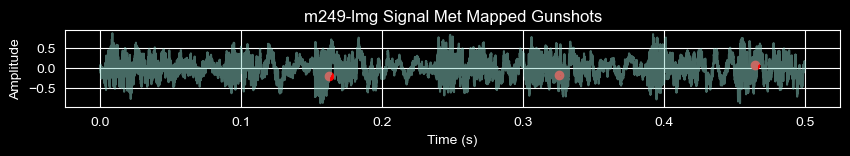

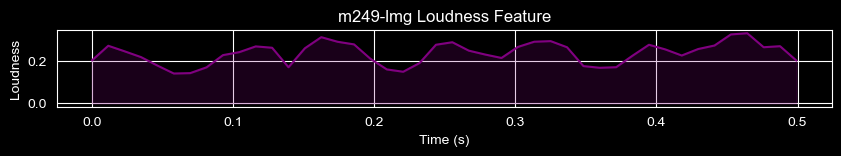

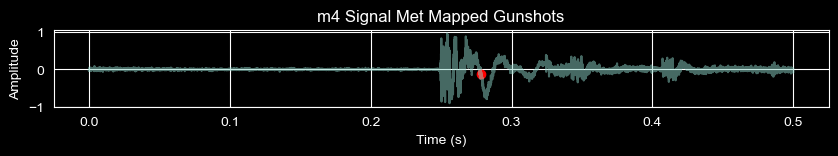

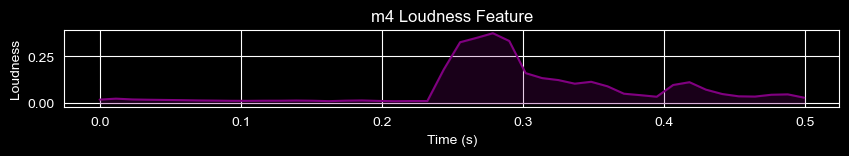

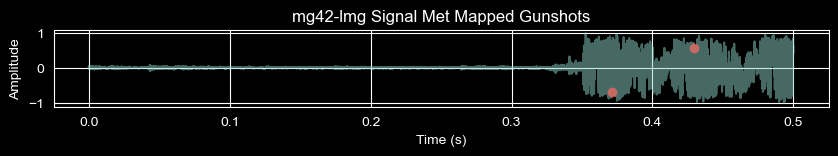

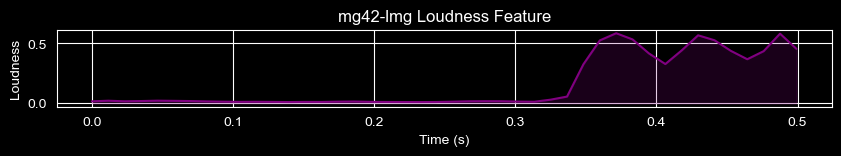

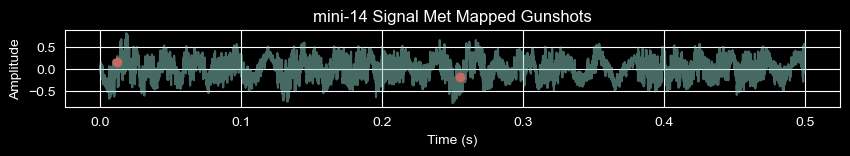

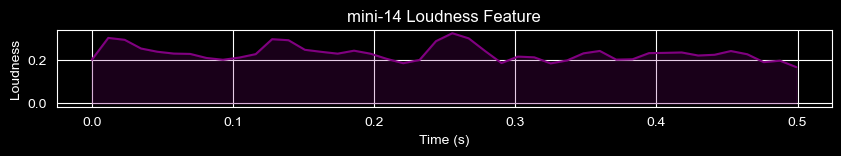

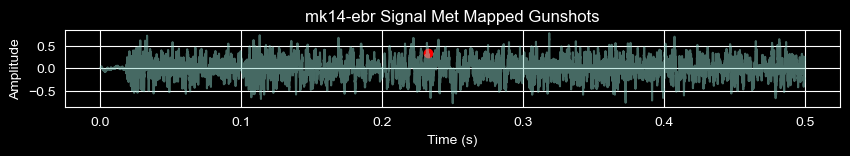

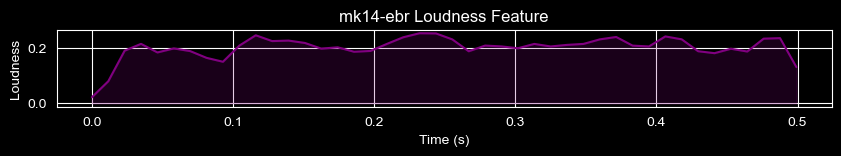

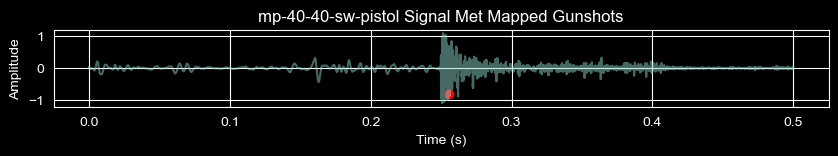

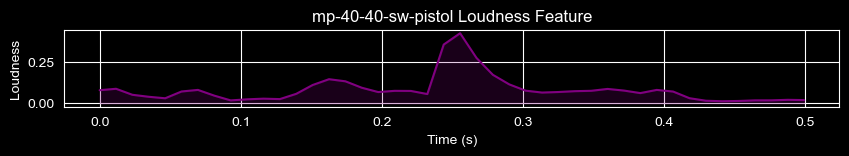

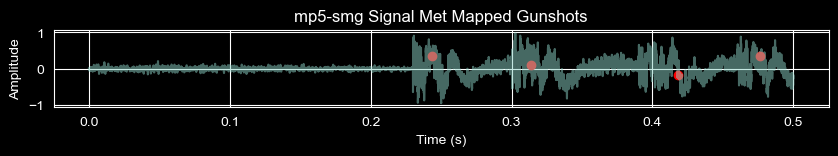

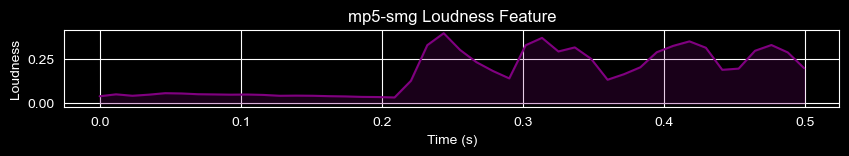

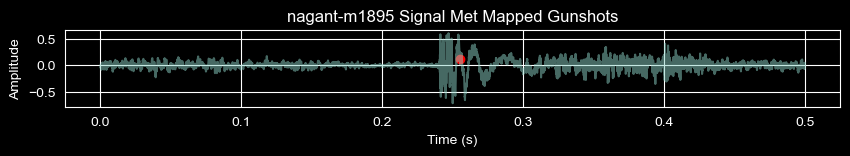

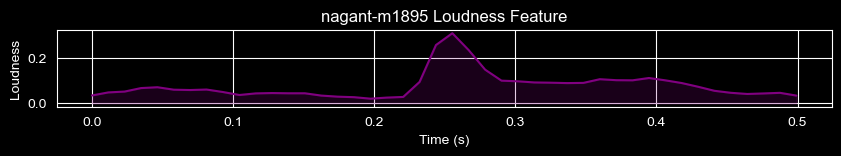

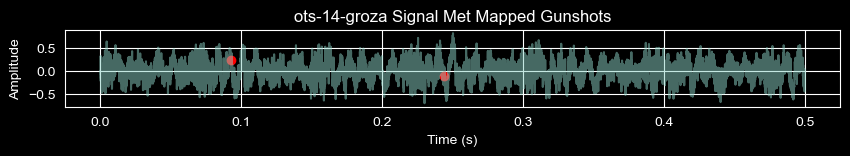

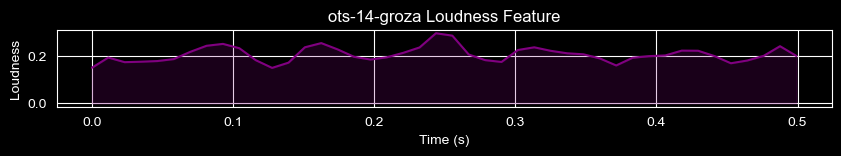

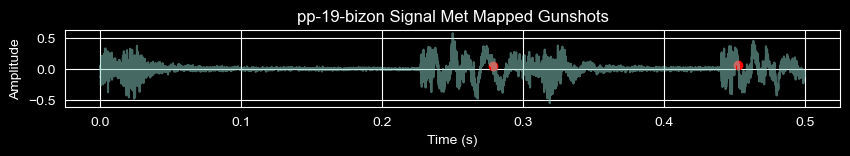

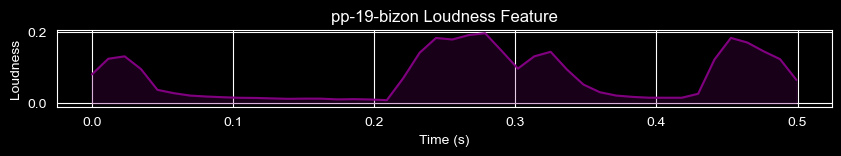

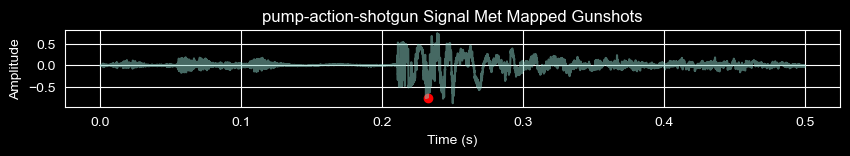

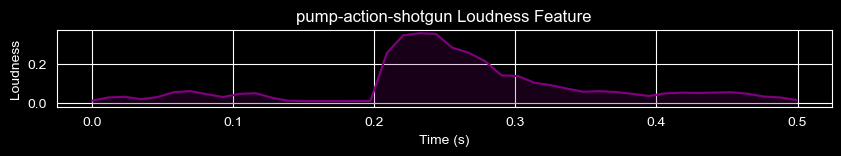

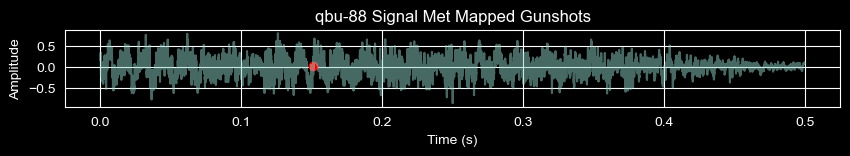

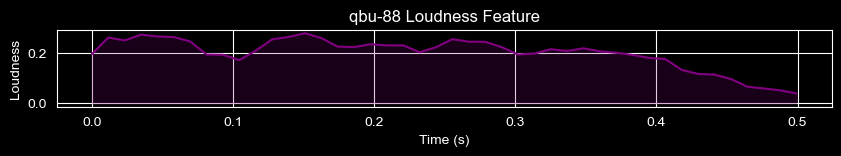

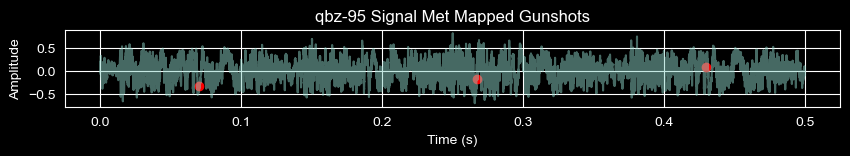

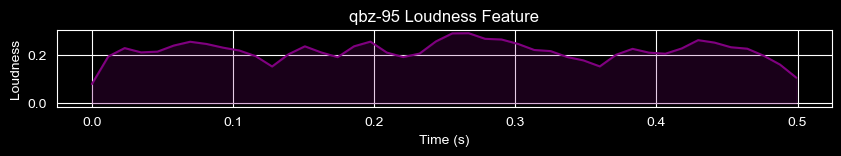

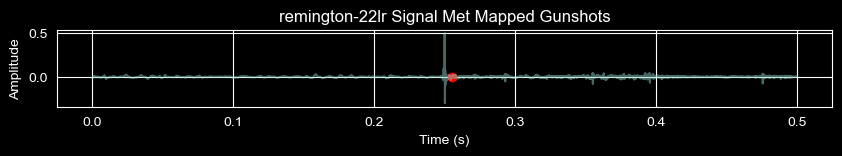

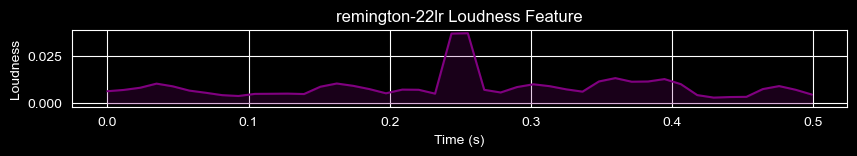

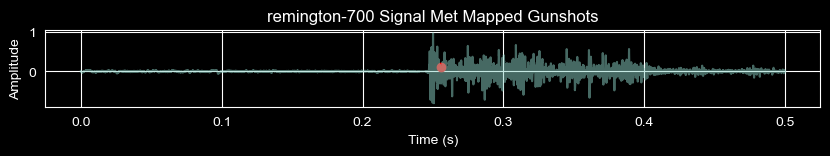

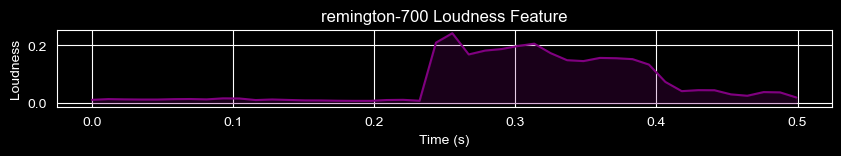

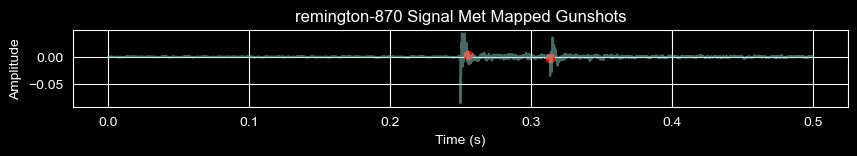

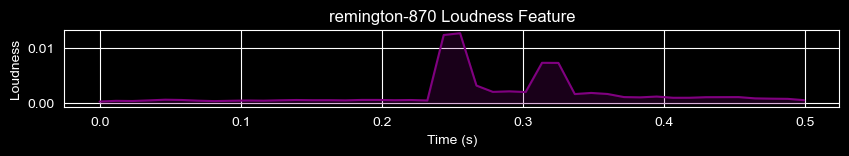

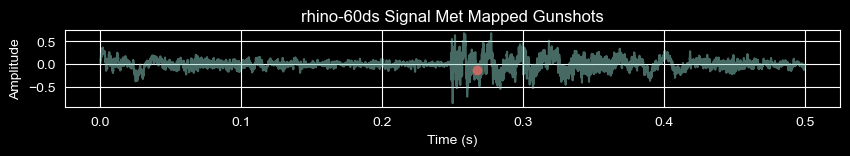

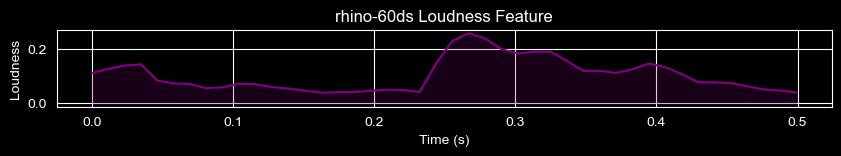

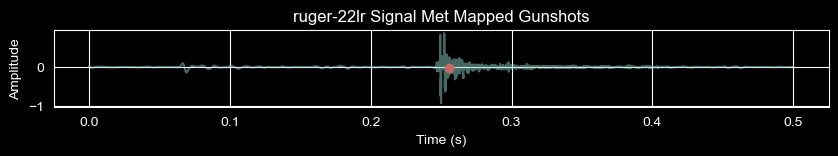

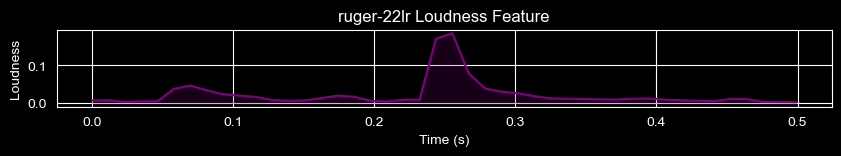

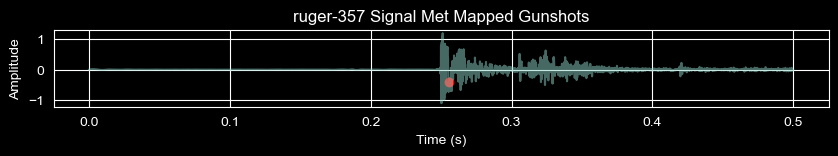

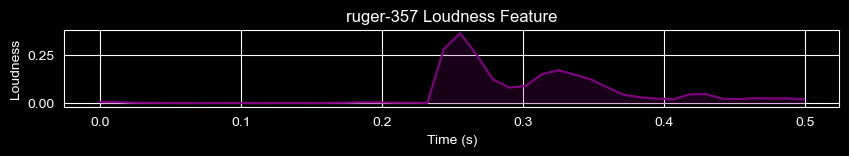

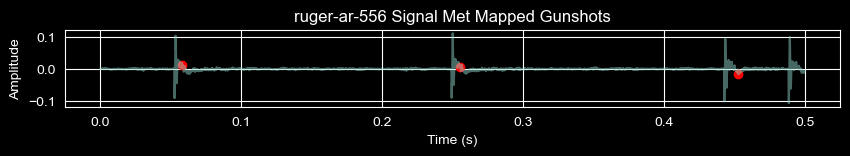

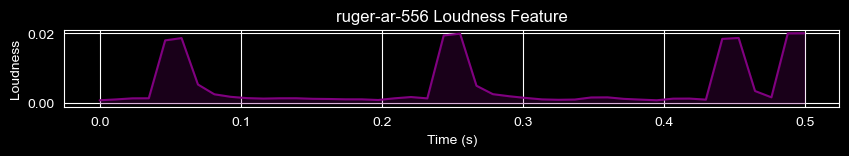

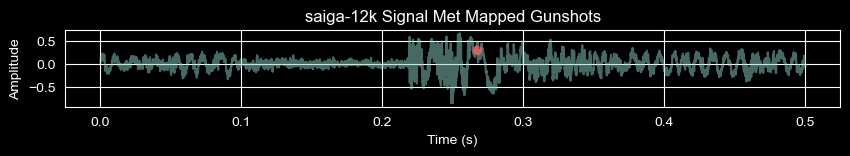

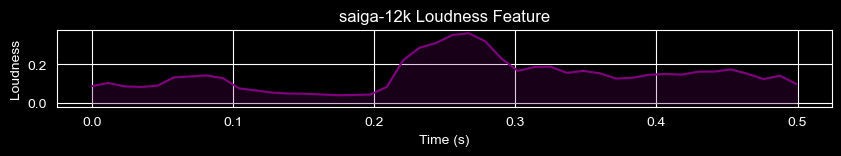

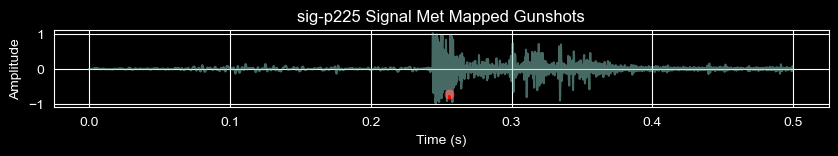

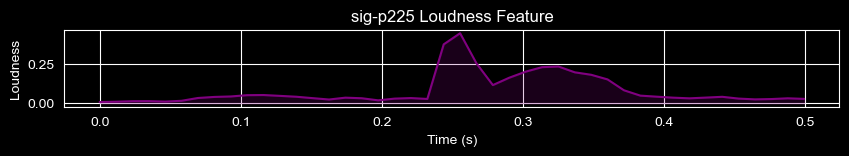

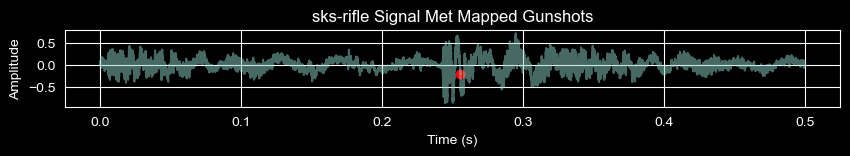

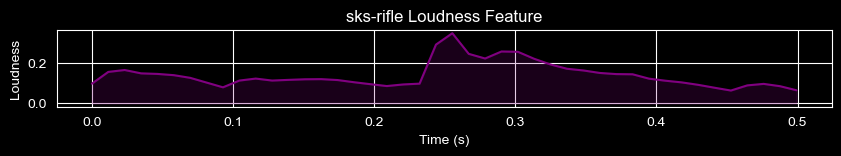

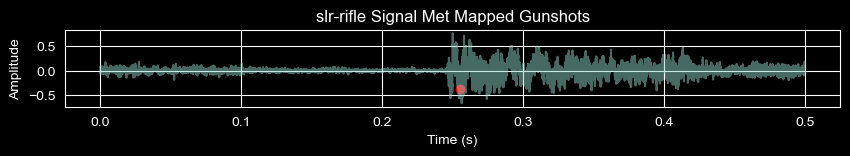

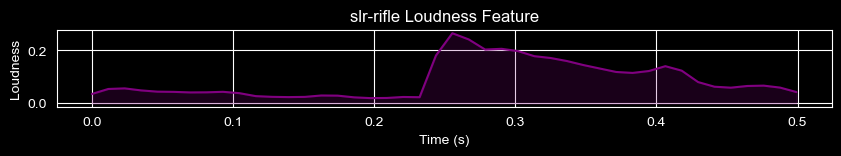

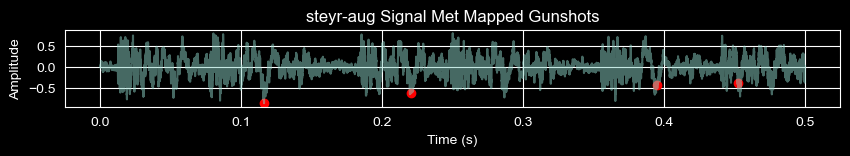

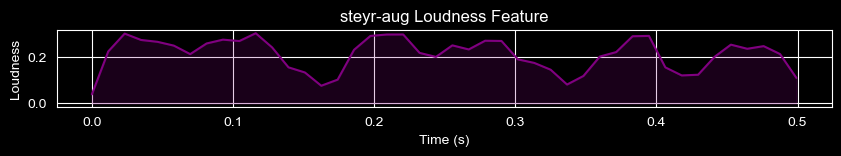

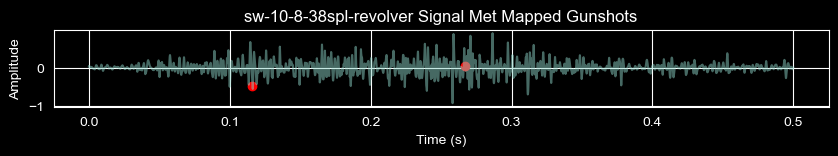

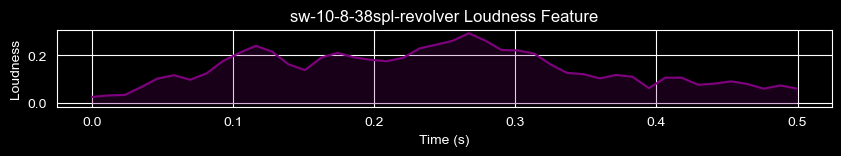

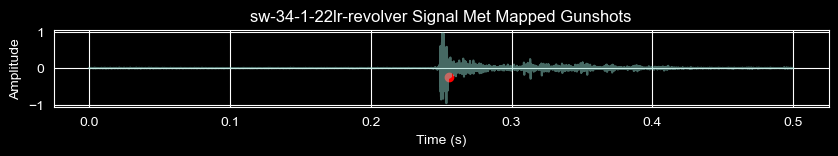

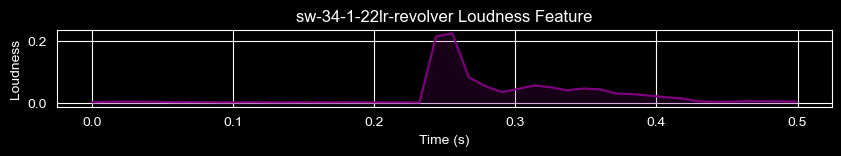

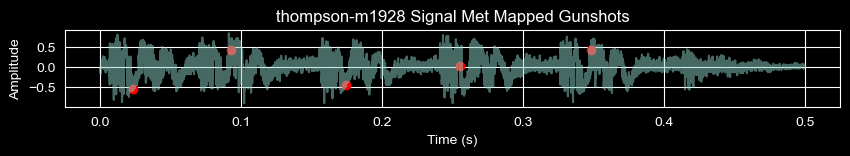

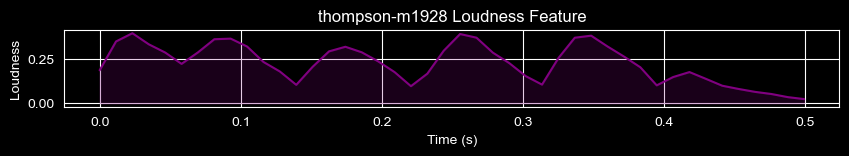

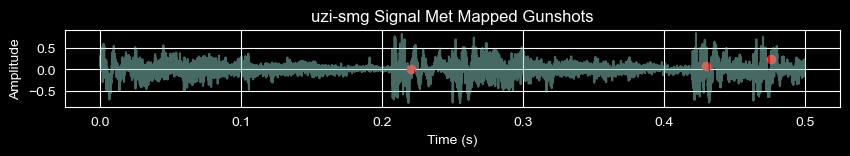

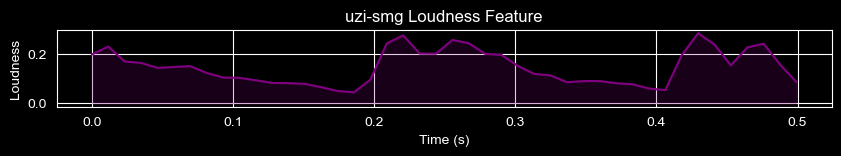

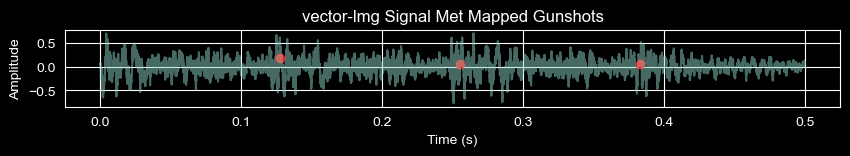

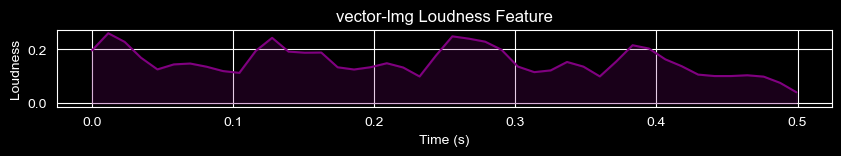

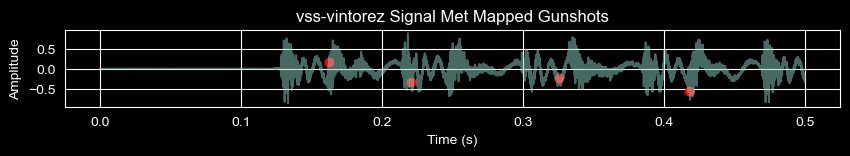

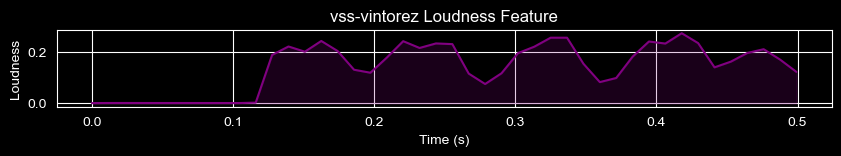

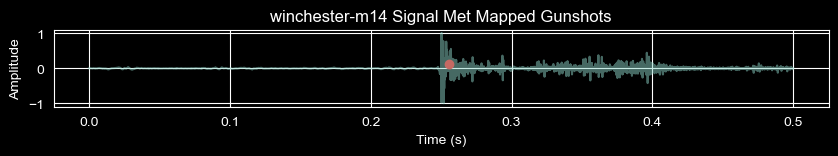

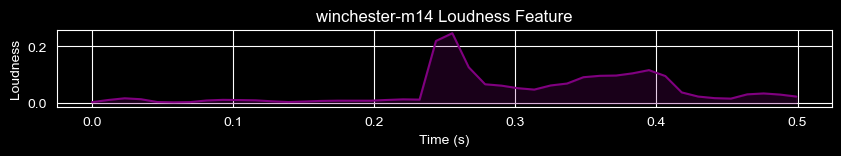

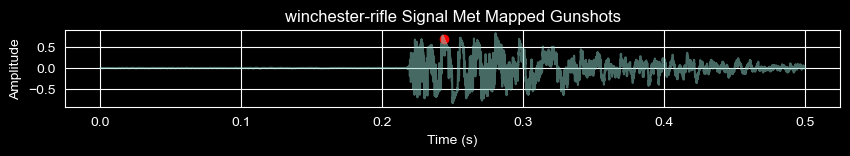

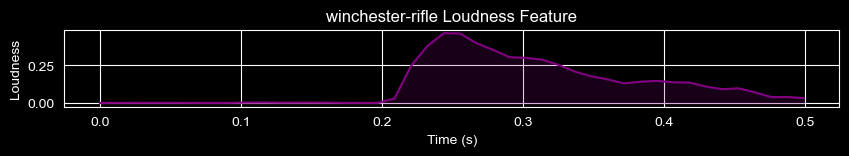

               firearm  \
0  38sws-dot38-caliber   
1  38sws-dot38-caliber   
2  38sws-dot38-caliber   
3  38sws-dot38-caliber   
4  38sws-dot38-caliber   

                                                                    filename  \
0  38sws-dot38-caliber_001_4a48b77c-72bf-4917-b8b0-da4f8b20a24b_chan3_v0.wav   
1  38sws-dot38-caliber_002_3ab0f1bb-f7fe-4cfe-a78e-11a263f75819_chan1_v0.wav   
2  38sws-dot38-caliber_003_090f69a9-885c-45fb-a807-f2661aaeb165_chan3_v0.wav   
3        38sws-dot38-caliber_004_907b513b-dd5e-4756-a20c-d785fb4f5dd7_v3.wav   
4   38sws-dot38-caliber_005_a7973dd2-b255-4711-9f98-484eda03c56c_mean_v0.wav   

                                                                                                                        path  
0  data/audio/original_dataset\38sws-dot38-caliber\38sws-dot38-caliber_001_4a48b77c-72bf-4917-b8b0-da4f8b20a24b_chan3_v0.wav  
1  data/audio/original_dataset\38sws-dot38-caliber\38sws-dot38-caliber_002_3ab0f1bb-f7fe-4cfe-a78e-11a263f75

In [4]:
from audio_dataset import audio_eda
audio_df, counts, dur, srates, peak_freqs = audio_eda("data/audio/original_dataset")
print(audio_df.head())

## 2.2 Image EDA

Inladen van de metadata

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

img_df = pd.read_csv("data/images/image_metadata.csv")
img_df.head()

Controleer of alle beelden goed zijn gedownload

In [ ]:
img_df["exists"] = img_df["path"].apply(lambda p: os.path.exists(p))
img_df

Basis EDA: Afmetingen & bestandsgrootte

In [ ]:
def get_img_stats(path):
    try:
        img = Image.open(path)
        width, height = img.size
        mode = img.mode
        file_size = os.path.getsize(path)
        return width, height, mode, file_size
    except:
        return None, None, None, None

img_df[["width", "height", "mode", "filesize"]] = img_df["path"].apply(
    lambda p: pd.Series(get_img_stats(p))
)

img_df

Visualiseer sample-afbeeldingen

In [ ]:
plt.figure(figsize=(12, 6))
for idx, row in img_df.head(3).iterrows():
    img = Image.open(row["path"])
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.title(row["model"])
    plt.axis("off")
plt.show()

Analyse van resoluties

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(img_df["width"], img_df["height"])
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution")
plt.show()

## 2.3 Text EDA

Na de extractie hebben we een simpele EDA gedaan om te kijken of de data bruikbaar is voor ons model. Voor 20 wapens konden we geen informatie vinden, maar dit bleek te liggen aan de bronpagina’s op GunsFandom die simpelweg geen infobox hadden. Dit is geen probleem voor de pipeline, maar wel een goed inzicht voor de uiteindelijke labeling. De data die we wel hebben, ziet er goed uit. De kolom type laat zien dat categorieen zoals "Assault rifle" en "Revolver" netjes worden herkend zonder dat er andere tekst in lekt. Ook de kalibers worden nu stabiel opgehaald als korte waarden (zoals 7.62 of 9mm). Omdat we deze tekst later toch nog gaan groeperen naar hoofdgroepen, was deze check vooral bedoeld om te zien of de extractie-logica werkt. De resultaten bevestigen dat de belangrijkste kenmerken betrouwbaar uit de ongestructureerde tekst worden gehaald.

In [6]:
from text_webscraping import clean_weapon_data
text_df2 = clean_weapon_data(text_df)
print(text_df2.head(15))

                        model  \
0         38sws-dot38-caliber   
1                       ak-12   
2                       ak-47   
3       arctic-warfare-magnum   
4                  beretta-92   
5                   colt-1911   
6                   daewoo-k2   
7                desert-eagle   
8       double-barrel-shotgun   
9                   dp-27-lmg   
10                     fn-p90   
11                    fn-scar   
12                      glock   
13                  glock-18c   
14  glock-19-9mm-luger-pistol   

                                                                           type  \
0                                                                     Not found   
1                                                                 Assault rifle   
2                                                                 Assault rifle   
3                                                                     Not found   
4                                                       

In [7]:
from text_webscraping import text_eda
text_eda(text_df2)

Top 10 Types
type
Not found                                                                20
Assault rifle                                                             5
Submachine gun                                                            4
Shotgun                                                                   4
Revolver                                                                  3
Semi-automatic Pistol(most models)Select-firemachine pistol(Glock 18)     3
Battle rifle                                                              2
General purpose machine gun                                               2
Bolt-                                                                     2
Semi-automatic Pistol                                                     1
Name: count, dtype: int64
Top 10 Calibers
caliber
                  20
7.62               7
12 gauge           3
9                  3
9mm                3
9x19mm             2
.22                2
.357               2
5.56

# 3 Preprocessing

## 3.1 Audio Preprocessing

De preprocessing richt zich op het omzetten van de ruwe audio naar bruikbare features voor de pipeline. Hiervoor wordt RMS-energie berekend om de volumevariaties van het geluid stabiel te meten. Daarna worden pieken in de energiecurve gedetecteerd met drempels voor hoogte, prominente pieken en minimale afstand tussen pieken. Dit zorgt ervoor dat echo’s of achtergrondgeluid niet worden meegeteld. Dit is namelijk wat wij tijdens EDA hebben al onderzocht. Per firearm worden de resultaten van alle 25 bestanden gemiddeld om twee features te verkrijgen: avg_shots_per_sec (het gemiddelde aantal schoten per seconde) en avg_loudness (gemiddelde piekamplitude).

In [8]:
from audio_dataset import extract_avg_features
audio_features = extract_avg_features("data/audio/original_dataset/")
print(audio_features.head(20))

                        firearm  avg_shots_per_sec  avg_loudness_amplitude
0           38sws-dot38-caliber               3.52                0.221897
1                         ak-12               3.28                0.356807
2                         ak-47               5.12                0.404454
3         arctic-warfare-magnum               3.84                0.387424
4                    beretta-92               5.52                0.297721
5                     colt-1911               3.12                0.371421
6                     daewoo-k2               6.40                0.424999
7                  desert-eagle               4.96                0.374295
8         double-barrel-shotgun               4.24                0.364326
9                     dp-27-lmg               7.68                0.283701
10                       fn-p90               5.92                0.193190
11                      fn-scar               7.92                0.394437
12                       

## 3.2 Image Preprocessing

#### 3.2.1 Introductie en Doelstelling

Om een vuurwapen te kunnen identificeren op basis van beeldmateriaal, is het niet voldoende om alleen de afbeelding te hebben. Ruwe afbeeldingen bevatten vaak veel 'ruis', zoals variërende achtergronden, schaduwen of andere objecten die een algoritme kunnen verwarren. Het doel van onze image-pipeline is om deze ruis te elimineren en de visuele data om te zetten in kwantitatieve kenmerken (features). Op die manier kunnen we een objectief onderscheid maken tussen bijvoorbeeld een compact handvuurwapen en een langwerpig geweer.

Voor de verwerking hebben we een pipeline ontwikkeld die bestaat uit vier cruciale fasen: organisatie, opschoning, feature extractie en data-opslag.

#### 3.2.2 Fase 1: Datastructuur en Organisatie

De eerste uitdaging bij het werken met multimodale data is de overzichtelijkheid. De ruwe afbeeldingen die via de Wikimedia API zijn binnengehaald, staan initieel ongesorteerd in één map. Voor een schaalbare pipeline is het essentieel dat de data gestructureerd is.

Onze aanpak: We hebben een script geschreven dat voor elk wapen automatisch een eigen submap aanmaakt binnen de directory data/images/raw/. Door de bestanden te hernoemen naar het specifieke wapenmodel en ze in deze mappen te plaatsen, creëren we een zogenaamde 'Single Source of Truth'. Dit stelt ons in staat om later eenvoudig extra afbeeldingen per wapen toe te voegen zonder de logica van de verwerkingsscripts aan te hoeven passen.

In [6]:
# Stap 1: Voorbereiding - Organiseer afbeeldingen in mappen per wapen
import shutil

# De afbeeldingen liggen nu rechtstreeks in data/images/
# We moeten ze verplaatsen naar data/images/raw/[weapon_name]/

raw_dir = "data/images/raw"
os.makedirs(raw_dir, exist_ok=True)

# Zet alle JPG-bestanden in submappen
for img_file in os.listdir("data/images"):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Maak de wapenaam (verwijder extensie)
        weapon_name = os.path.splitext(img_file)[0]
        weapon_dir = os.path.join(raw_dir, weapon_name)
        os.makedirs(weapon_dir, exist_ok=True)
        
        # Verplaats afbeelding
        src = os.path.join("data/images", img_file)
        dst = os.path.join(weapon_dir, img_file)
        
        if os.path.exists(src) and not os.path.exists(dst):
            shutil.copy(src, dst)
            print(f"Gekopieerd: {img_file} → {weapon_dir}/")

Gekopieerd: ak-12.jpg → data/images/raw\ak-12/
Gekopieerd: ak-47.jpg → data/images/raw\ak-47/
Gekopieerd: arctic-warfare-magnum.jpg → data/images/raw\arctic-warfare-magnum/
Gekopieerd: beretta-92.jpg → data/images/raw\beretta-92/
Gekopieerd: colt-1911.jpg → data/images/raw\colt-1911/
Gekopieerd: daewoo-k2.jpg → data/images/raw\daewoo-k2/
Gekopieerd: desert-eagle.jpg → data/images/raw\desert-eagle/
Gekopieerd: double-barrel-shotgun.jpg → data/images/raw\double-barrel-shotgun/
Gekopieerd: dp-27-lmg.jpg → data/images/raw\dp-27-lmg/
Gekopieerd: fn-p90.jpg → data/images/raw\fn-p90/
Gekopieerd: fn-scar.jpg → data/images/raw\fn-scar/
Gekopieerd: glock-18c.jpg → data/images/raw\glock-18c/
Gekopieerd: glock-19-9mm-luger-pistol.jpg → data/images/raw\glock-19-9mm-luger-pistol/
Gekopieerd: glock.jpg → data/images/raw\glock/
Gekopieerd: high-standard-22lr.jpg → data/images/raw\high-standard-22lr/
Gekopieerd: hk-g36c.jpg → data/images/raw\hk-g36c/
Gekopieerd: hk-ump45.jpg → data/images/raw\hk-ump45/

#### 3.2.3 Fase 2: Transformatie – Van Foto naar Silhouet

De kern van de transformatiefase is het scheiden van de hoofdzaak (het wapen) en de bijzaak (de achtergrond). Dit proces noemen we Data Preprocessing.

Techniek en Uitdagingen: We maken gebruik van het Rembg-model, een deep learning algoritme gebaseerd op de U²-Net architectuur. Dit model voert een semantische segmentatie uit; het herkent welk deel van de foto een object is en welk deel de achtergrond. De output is een PNG-bestand waarbij de achtergrond volledig transparant is gemaakt (het alpha-kanaal).

De grootste uitdaging hierbij is dat niet elke afbeelding van dezelfde kwaliteit is. Sommige foto’s hebben weinig contrast, waardoor de segmentatie soms delen van het wapen weg kan snijden. Door echter alleen het alpha-kanaal te analyseren met OpenCV, kunnen we een nauwkeurig silhouet (contour) trekken om het wapen heen.

In [2]:
# Stap 2: Voer beeldverwerking uit (achtergrond verwijderen + meten)
import os
import pandas as pd
from PIL import Image
from image_api import process_weapon_images
# Alle wapens verwerken
processed_df = process_weapon_images(
    raw_base_dir="data/images/raw",
    processed_base_dir="data/images/processed"
)

# Opslaan naar CSV
processed_df.to_csv("data/images/weapon_analysis.csv", index=False)

print("RESULTATEN BEELDVERWERKING:")
print(f"Totale processed: {len(processed_df)} images")
print(f"opgeslagen naar data/images/weapon_analysis.csv")
print("\n" + processed_df.to_string())

ImportError: cannot import name 'process_weapon_images' from 'image_api' (C:\Users\mkako\Portables\Projects\sleeping_api-s\image_api.py)

#### 3.2.4 Fase 3: Feature Engineering – De Aspect Ratio

Nadat de achtergrond is verwijderd, kunnen we overgaan tot Feature Engineering. Hierbij extraheren we specifieke eigenschappen die iets zeggen over het type wapen. Het belangrijkste kenmerk dat we hier berekenen is de Aspect Ratio (de verhouding tussen breedte en hoogte).

De Classificatie-logica: Wapens hebben vaak een herkenbare vormfactor. Een geweer is in de regel veel langer dan dat het hoog is, zeker wanneer er een kolf aanwezig is voor schouderondersteuning. Een pistool is compacter.

Ratio > 2.0: Het object is meer dan twee keer zo breed als hoog. Dit duidt op een langwerpig wapen, vaak een geweer of shotgun (2-handed).

Ratio ≤ 2.0: Het object is compacter. Dit duidt meestal op een handvuurwapen zoals een pistool of revolver (1-handed).

Deze automatische meting helpt de FBI om snel een eerste schifting te maken in grote hoeveelheden beeldmateriaal.

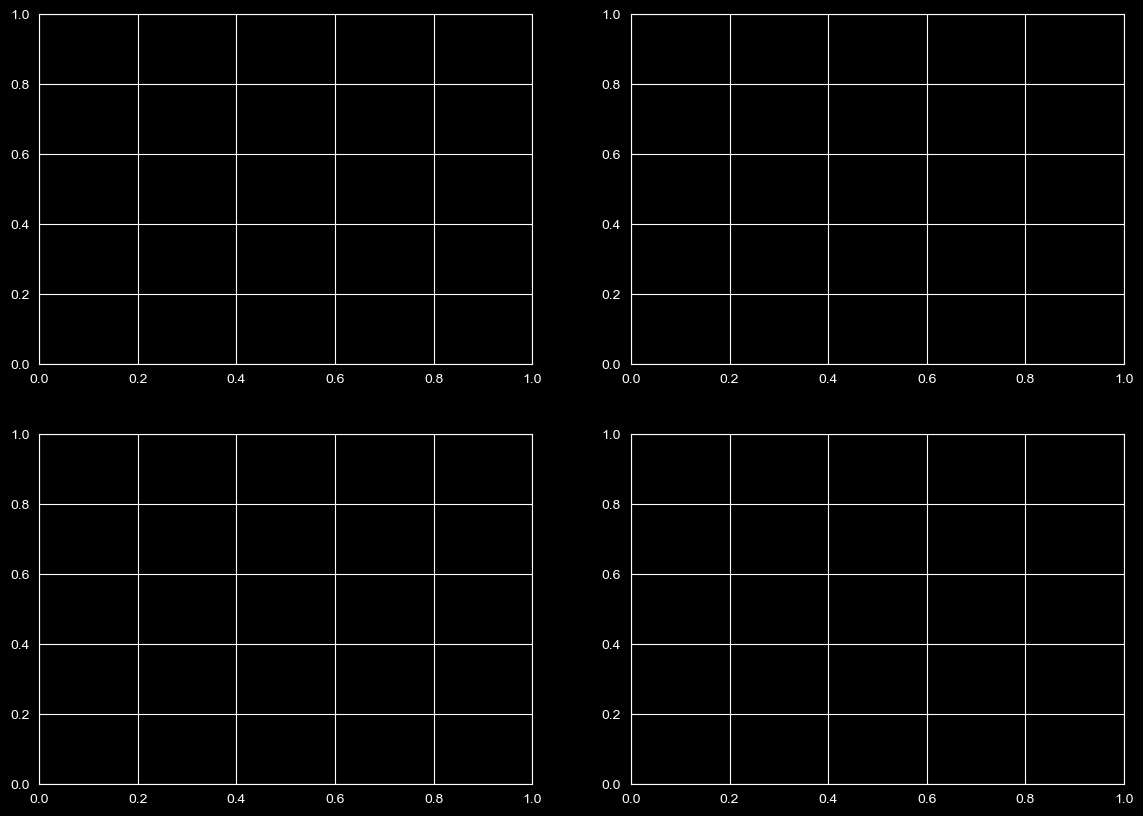

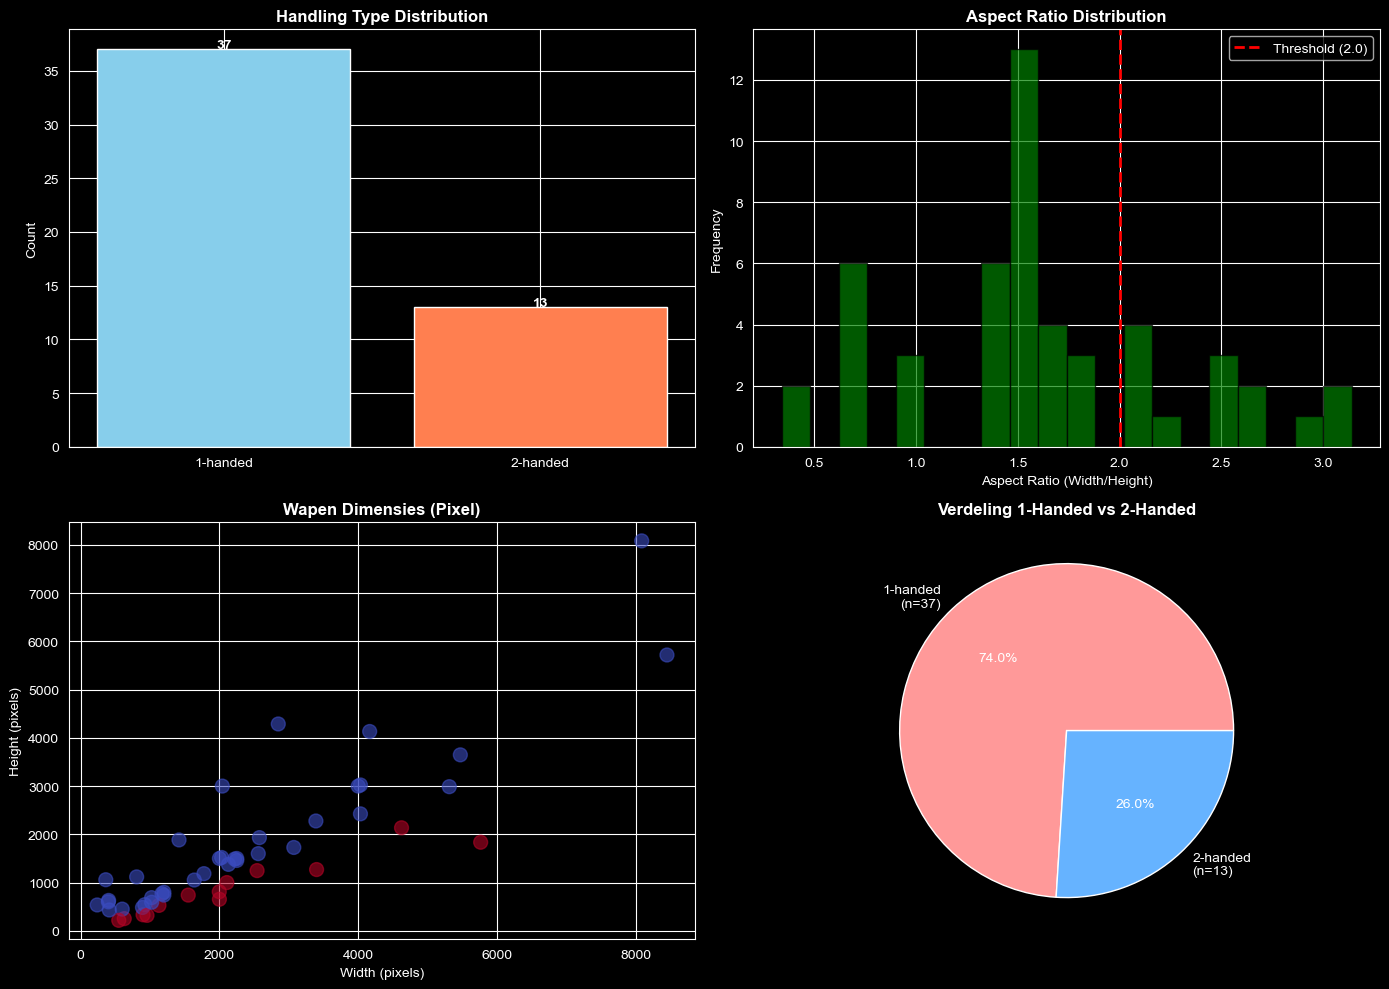

SAMENVATTING PER WAPEN
                           Avg Width  Avg Height  Avg Ratio  Handling              Stock Label
weapon_key                                                                                    
ak-12                         2543.0      1248.0       2.04  2-handed        Lange loop / Kolf
ak-47                          900.0       332.0       2.71  2-handed        Lange loop / Kolf
arctic-warfare-magnum         1998.0       810.0       2.47  2-handed        Lange loop / Kolf
beretta-92                    2130.0      1377.0       1.55  1-handed  Compact / Handvuurwapen
colt-1911                     2220.0      1488.0       1.49  1-handed  Compact / Handvuurwapen
daewoo-k2                     2000.0       654.0       3.06  2-handed        Lange loop / Kolf
desert-eagle                  1777.0      1185.0       1.50  1-handed  Compact / Handvuurwapen
double-barrel-shotgun         4624.0      2136.0       2.16  2-handed        Lange loop / Kolf
dp-27-lmg                  

In [21]:
# Stap 3: Visualisatie & Analyse

# Distributieverloop
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Handling type verdeling (1-handed vs 2-handed)
handling_counts = processed_df['handling_type'].value_counts()
axes[0, 0].bar(handling_counts.index, handling_counts.values, color=['skyblue', 'coral'])
axes[0, 0].set_title('Handling Type Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(handling_counts.values):
    axes[0, 0].text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# 2. Aspect Ratio distributie
axes[0, 1].hist(processed_df['aspect_ratio'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(2.0, color='red', linestyle='--', linewidth=2, label='Threshold (2.0)')
axes[0, 1].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Aspect Ratio (Width/Height)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Pixel dimensions
axes[1, 0].scatter(processed_df['pixel_width'], processed_df['pixel_height'], 
                   c=processed_df['has_stock_prediction'], cmap='coolwarm', s=100, alpha=0.6)
axes[1, 0].set_title('Wapen Dimensies (Pixel)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Width (pixels)')
axes[1, 0].set_ylabel('Height (pixels)')

# 4. Aantal afbeeldingen per handling type
stock_dist = processed_df[['handling_type', 'has_stock_prediction']].groupby('handling_type').size()
axes[1, 1].pie(stock_dist.values, labels=[f"{x}\n(n={y})" for x, y in zip(stock_dist.index, stock_dist.values)],
               autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
axes[1, 1].set_title('Verdeling 1-Handed vs 2-Handed', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Samenvatting per wapen
print("SAMENVATTING PER WAPEN")
summary = processed_df.groupby('weapon_key').agg({
    'pixel_width': 'mean',
    'pixel_height': 'mean',
    'aspect_ratio': 'mean',
    'handling_type': 'first',
    'stock_label_nl': 'first'
}).round(2)
summary.columns = ['Avg Width', 'Avg Height', 'Avg Ratio', 'Handling', 'Stock Label']
print(summary.to_string())

#### 3.2.5 Fase 4: Validatie en Database Integratie (Load)

De laatste stap in onze pipeline is het laden van de getransformeerde data in een bruikbaar formaat voor het analyse-team.

Exploratieve Analyse (EDA): Door de resultaten te visualiseren in scatter plots en histogrammen, kunnen we de robuustheid van onze pipeline controleren. Hierbij kijken we specifiek naar 'uitbijters'. Een Desert Eagle kan bijvoorbeeld door zijn enorme loop een ratio hebben die dicht bij die van een kort geweer ligt. Deze visuele validatie is essentieel om de betrouwbaarheid van het systeem te waarborgen.

Oplossing voor de lange termijn: De uiteindelijke data – inclusief de paden naar de opgeschoonde afbeeldingen, de afmetingen in pixels en de voorspelde handling-methode – wordt opgeslagen in een SQLite database (image_features tabel). Dit zorgt ervoor dat de data persistent is, doorzoekbaar via SQL-queries, en direct gekoppeld kan worden aan de audio-kenmerken via de weapon_key. Hiermee is de end-to-end pipeline voltooid: van een ruwe pixel tot een gestructureerd datapunt in de database van de FBI.

In [ ]:
import sqlite3

# Maak verbinding met je database
conn = sqlite3.connect("weapons_data.db")

# Sla de verwerkte image data op in de database
processed_df.to_sql('image_features', conn, if_exists='replace', index=False) 

# Check of het erin staat
check_df = pd.read_sql_query("SELECT weapon_key, handling_type FROM image_features LIMIT 5", conn)
print(check_df)

conn.close()

## 3.3 Text Preprocessing

Voor de tekstverwerking hebben we de ruime variatie aan beschrijvingen gestandaardiseerd naar drie hoofdcategorieen: rifle, pistol en shotgun. Dit is een belangrijke stap in de feature engineering, omdat het model beter presteert op een beperkt aantal duidelijke klassen dan op tientallen specifieke subtypen zoals 'submachine gun', 'revolver' of 'assault rifle'.

De transformatie gebeurt via een mapping functie die zoekt naar specifieke keywords binnen de eerder geextraheerde type kolom. Alle varianten van automatische wapens en machinegeweren zijn ondergebracht bij 'rifle', terwijl revolvers en machinepistolen onder 'pistol' vallen. Wapens waarbij geen duidelijke match werd gevonden, krijgen het label 'other'. Dit zorgt voor een gebalanceerde dataset die direct bruikbaar is als target variabele voor classificatie.

De caliber kolom is in deze fase bewust ongewijzigd gelaten om de originele technische specificaties te behouden. Hoewel deze kolom nog wat ruis bevat door de squashed tekst van de bron, zijn de belangrijkste waarden (zoals 9mm en 7.62) nu goed gescheiden van de wapentypen. Deze opgeschoonde feature set vormt, samen met de audio kenmerken, de uiteindelijke input voor de pipeline.

In [16]:
from text_webscraping import simplify_types
text_features = simplify_types(text_df)
print(text_features.head(59))

                          model     type                    caliber
0           38sws-dot38-caliber    other                of a weapon
1                         ak-12    rifle                      AK-12
2                         ak-47    rifle                       7.62
3         arctic-warfare-magnum    other                           
4                    beretta-92   pistol                     9x19mm
5                     colt-1911    other                           
6                     daewoo-k2    rifle             5.56x45mm NATO
7                  desert-eagle   pistol                       .357
8         double-barrel-shotgun    other                           
9                     dp-27-lmg    other                           
10                       fn-p90    rifle                        5.7
11                      fn-scar    rifle                       7.62
12                        glock   pistol                        9mm
13                    glock-18c   pistol        

# 4. Pipeline

In [3]:
from main import merge_features
master_dataset = merge_features(text_features[['model']], text_features, audio_features, processed_df)
display(master_dataset.head(58))

NameError: name 'text_features' is not defined

### 4.1 Pipeline cell:

INFO: Starting pipeline


Searching for 38sws-dot38-caliber...
No image found for 38sws-dot38-caliber.
Searching for ak-12...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/c2/5%2C45mm_AK-12_6P70_assault_rifle_at_Military-technical_forum_ARMY-2016_03_noBG.png
Searching for ak-47...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/f/f6/AK-47_assault_rifle.jpg
Searching for arctic-warfare-magnum...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/0/0f/AWM-338-white.jpg
Searching for beretta-92...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/2/24/Beretta_92S_%28cropped%29.jpg
Searching for colt-1911...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/cf/Colt_M1911_Pistol_from_1912_Army_manual.png
Searching for daewoo-k2...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/5/59/Daewoo_K2_rifle_1.jpg
Searching for desert-eagle...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/8/81/2014-_Desert_Eagle_.50_Action_Express_Semi-Automatic_Pis

INFO: Pipeline finished


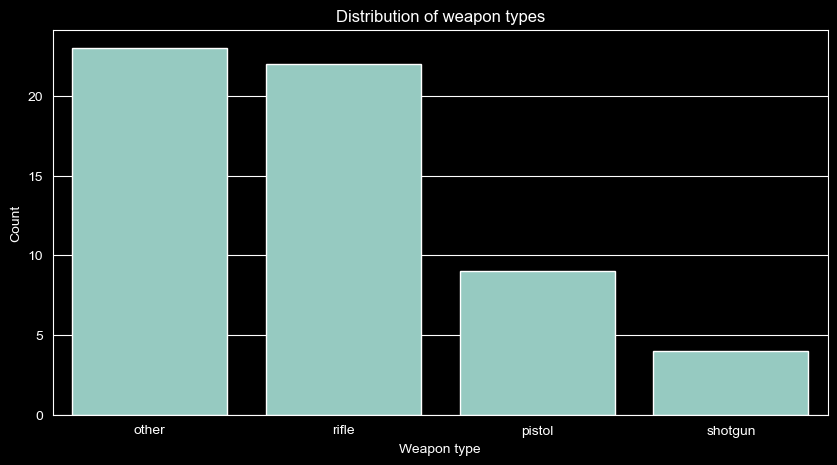


Sample of final dataset:


,model,type,caliber,avg_shots_per_sec,avg_loudness_amplitude,image_name,pixel_width,pixel_height,aspect_ratio,has_stock_prediction,handling_type,stock_label_nl
0,38sws-dot38-caliber,other,of a weapon,3.52,0.221897,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ak-12,rifle,AK-12,3.28,0.356807,ak-12.jpg,2543.0,1248.0,2.038,1.0,2-handed,Met kolf
2,ak-47,rifle,7.62,5.12,0.404454,ak-47.jpg,900.0,332.0,2.711,1.0,2-handed,Met kolf
3,arctic-warfare-magnum,other,,3.84,0.387424,arctic-warfare-magnum.jpg,1998.0,810.0,2.467,1.0,2-handed,Met kolf
4,beretta-92,pistol,9x19mm,5.52,0.297721,beretta-92.jpg,2130.0,1377.0,1.547,0.0,1-handed,Zonder kolf


In [1]:
import os
import logging
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from image_api import *
from text_webscraping import *
from audio_dataset import *
from main import *
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
def run_weapon_data_pipeline():
    try:
        logging.info("Starting pipeline")
        audio_path = "data/audio/original_dataset/"
        models = [os.path.splitext(f)[0] for f in os.listdir(audio_path)]
        base_df = pd.DataFrame({"model": models})
        img_api = ImageAPI(
            "https://commons.wikimedia.org/w/api.php",
            {"User-Agent": "Pipeline/1.0"}
        )
        image_df = img_api.fetch_images_for_models(models)
        text_df = get_fandom_texts(base_df)
        text_features = simplify_types(clean_weapon_data(text_df))
        audio_features = extract_avg_features(audio_path)
        image_features = process_weapon_images(
            raw_base_dir="data/images/raw",
            processed_base_dir="data/images/processed"
        )
        master_df = merge_features(
            base_df,
            text_features,
            audio_features,
            image_features
        )
        with sqlite3.connect("weapons_data.db") as conn:
            master_df.to_sql(
                "final_weapon_data",
                conn,
                if_exists="replace",
                index=False
            )
        logging.info("Pipeline finished")
        return master_df
    except Exception as e:
        logging.error(f"Pipeline failed: {e}")
        return None

final_dataset = run_weapon_data_pipeline()
if final_dataset is not None:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=final_dataset, x="type")
    plt.title("Distribution of weapon types")
    plt.xlabel("Weapon type")
    plt.ylabel("Count")
    plt.show()
    print("\nSample of final dataset:")
    display(final_dataset.head())

# 5. Referentielijst:

[ChatGPT, 2025. Prompt 1: Using Special search query in web scraping](https://chatgpt.com/share/695ace2a-4144-800a-b47e-d1787e6ce53c)

[ChatGPT, 2026. Prompt 3: Getting filtering spaces right](https://chatgpt.com/share/69737cb1-59a8-800a-b37a-25b53033de4e)

[ChatGPT, 2026. Prompt 1: for loop fix for peaks](https://chatgpt.com/share/6914546f-d378-800a-a6f5-251d076f6149)

[ChatGPT, 2026. Prompt 1: Detecting peaks](https://chatgpt.com/share/6914c756-9450-800a-9dce-4b2c992223bb)

[ChatGPT, 2026. Prompt 1: Get all images for firearm models from the audio dataset names](https://chatgpt.com/share/68ebef06-e254-800a-b767-1649251a10ec)